<a href="https://colab.research.google.com/github/eeuunnjjiii/kaggle_survey2021/blob/main/kaggle_survey_2021_EJJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글 데이터 연동하기

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eunjijeong","key":"29fdf1c9b4bee7ef56c5520fc84d41dc"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c kaggle-survey-2021
!unzip kaggle_survey_2021_responses.csv.zip

  0% 0.00/55.2k [00:00<?, ?B/s]
100% 55.2k/55.2k [00:00<00:00, 20.1MB/s]
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 84.0MB/s]
  0% 0.00/2.86M [00:00<?, ?B/s]
100% 2.86M/2.86M [00:00<00:00, 94.6MB/s]
Archive:  kaggle_survey_2021_responses.csv.zip
  inflating: kaggle_survey_2021_responses.csv  


# 데이터 불러오기

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [4]:
response = pd.read_csv('kaggle_survey_2021_responses.csv')
print(response.shape)
response.head(3)

(25974, 369)


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool

# 전처리 - 질문 통합

In [5]:
res = response.copy()

# index 0번 질문 삭제
res.drop(0, inplace=True)

In [6]:
def total_answer(column):
  """
  컬럼별로 나누어진 응답을 통합하는 함수
  column : 컬럼명
  """

  # 해당 컬럼명이 들어간 컬럼 추출
  col = res.columns[res.columns.str.contains(column)]
  tmp = res[col]
  # 결측치 ''로 채우기
  tmp = tmp.fillna('')
  # 컬럼별 응답 콤마(,)로 더하기
  total = tmp.apply(','.join, axis=1)

  # 정규표현식으로 필요없는 콤마(,) 처리
  import re
  ls = []
  for i in total:
    ls.append(re.sub(',{2,}', ',', i).strip(',')) ## 콤마가 2개 이상인 경우 하나로 바꾸기

  # 나눠진 응답 삭제
  res.drop(col, axis=1, inplace=True)

  # 통합 응답 추가
  res[column] = ls

In [7]:
for i in range(7, 43):
  num = 'Q'+str(i) ## Q7, Q8, ...
  total_answer(num) ## 함수 적용

In [8]:
res.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,Google Cloud Compute Engine,Google Cloud Storage (GCS),No / None,PostgreSQL,,None,,No / None,,No / None,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ..."
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,"SQL,C,C++,Java",Python,"Notepad++ , Jupyter Notebook","Kaggle Notebooks,Colab Notebooks","A cloud computing platform (AWS, Azure, GCP, h...",None,Never,Matplotlib,Under 1 year,Scikit-learn,"Linear or Logistic Regression,Decision Trees o...",,,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,Build and/or run the data infrastructure that ...,"60,000-69,999",$0 ($USD),"Google Cloud Platform (GCP) , Oracle Cloud",,Google Cloud Compute Engine,,None,"MySQL ,SQLite ,Oracle Database ,Google Cloud SQL",,"Google Data Studio,Qlik",,"Automated model selection (e.g. auto-sklearn, ...",Google Cloud AutoML,None,,"Kaggle Learn Courses,Cloud-certification progr...","Advanced statistical software (SPSS, SAS, etc.)","Journal Publications (peer-reviewed journals, ..."
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,"Python,C++,Java",Python,"PyCharm , Jupyter Notebook,Other",Kaggle Notebooks,A laptop,Other,Never,Matplotlib,I do not use machine learning methods,,,,,Academics/Education,"1000-9,999 employees",0,I do not know,None of these activities are an important part...,$0-999,$0 ($USD),"None, Amazon Web Services (AWS) , Google Cloud...",,"Microsoft Azure Virtual Machines , Google Clo...",,"DataRobot, Azure Machine Learning Studio , Go...","MySQL ,MongoDB ,MySQL ,PostgreSQL ,MongoDB",MySQL,"None,Microsoft Power BI,Tableau",,"No / None,Automated model selection (e.g. auto...",DataRobot AutoML,"No / None, TensorBoard",I do not share my work publicly,DataCamp,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),YouTube (Kaggl..."
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,Python,"Spyder , Jupyter Notebook",Colab Notebooks,"A cloud computing platform (AWS, Azure, GCP, h...",NVIDIA GPUs,More than 25 times,Matplotlib,5-10 years,"Scikit-learn , TensorFlow , Keras","Dense Neural Networks (MLPs, etc),Convolutiona...","General purpose image/video tools (PIL, cv2, s...",None,Academics/Education,"1000-9,999 employees",0,I do not know,Do research that advances the state of the art...,"30,000-39,999",$0 ($USD),"Amazon Web Services (AWS) , Microsoft Azure",,"Microsoft Azure Virtual Machines , Google Clo...",,None,None,,None,,None,,None,,"Coursera,edX","Local development environments (RStudio, Jupyt...","YouTube (Kaggle YouTube, Cloud AI Adventures, ..."
5,781,45-49,Man,India,Doctoral degree,Other,< 1 years,"Python,C,MATLAB",Python,"Spyder , MATLAB , Jupyter Notebook",Google Cloud Datalab,"A cloud computing platform (AWS, Azure, GCP, h...",None,Never,"Matplotlib , Seaborn , Ggplot / ggplot2",10-20 years,"Scikit-learn , PyTorch , LightGBM","Linear or Logistic Regression,Decision Trees o...",,,Academics/Education,50-249 employees,5-9,We use ML methods for generating insights (but...,Analyze and understand data to influence

# 항목별 결과 조회

## Professionals VS Non-Professionals

In [9]:
# Student, not employed, never spent money in the cloud : nonpro
nonpro = res[(res.Q5 == 'Student') | (res.Q5 == 'Currently not employed')|(res.Q26 == '$0 ($USD)')]
pro = res.drop(nonpro.index)
print(nonpro.shape, pro.shape)

(14693, 43) (11280, 43)


In [10]:
# 레이블 붙이기
res.loc[(res.Q5 == 'Student') | (res.Q5 == 'Currently not employed')|(res.Q26 == '$0 ($USD)'), 'label'] = 'nonpro'
res['label'] = res['label'].fillna('pro')
res.head(3)

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,label
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,Google Cloud Compute Engine,Google Cloud Storage (GCS),No / None,PostgreSQL,,None,,No / None,,No / None,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ...",pro
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,"SQL,C,C++,Java",Python,"Notepad++ , Jupyter Notebook","Kaggle Notebooks,Colab Notebooks","A cloud computing platform (AWS, Azure, GCP, h...",None,Never,Matplotlib,Under 1 year,Scikit-learn,"Linear or Logistic Regression,Decision Trees o...",,,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,Build and/or run the data infrastructure that ...,"60,000-69,999",$0 ($USD),"Google Cloud Platform (GCP) , Oracle Cloud",,Google Cloud Compute Engine,,None,"MySQL ,SQLite ,Oracle Database ,Google Cloud SQL",,"Google Data Studio,Qlik",,"Automated model selection (e.g. auto-sklearn, ...",Google Cloud AutoML,None,,"Kaggle Learn Courses,Cloud-certification progr...","Advanced statistical software (SPSS, SAS, etc.)","Journal Publications (peer-reviewed journals, ...",nonpro
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,"Python,C++,Java",Python,"PyCharm , Jupyter Notebook,Other",Kaggle Notebooks,A laptop,Other,Never,Matplotlib,I do not use machine learning methods,,,,,Academics/Education,"1000-9,999 employees",0,I do not know,None of these activities are an important part...,$0-999,$0 ($USD),"None, Amazon Web Services (AWS) , Google Cloud...",,"Microsoft Azure Virtual Machines , Google Clo...",,"DataRobot, Azure Machine Learning Studio , Go...","MySQL ,MongoDB ,MySQL ,PostgreSQL ,MongoDB",MySQL,"None,Microsoft Power BI,Tableau",,"No / None,Automated model selection (e.g. auto...",DataRobot AutoML,"No / None, TensorBoard",I do not share my work publicly,DataCamp,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),YouTube (Kaggl...",nonpro


In [11]:
# 전체적으로 한번 살펴보기
for i in nonpro.columns[1:]:
  print(i)
  print('------Nonpro------')
  print(nonpro[i].value_counts(normalize=True))
  print('------Pro------')
  print(pro[i].value_counts(normalize=True))
  print('\n')

Q1
------Nonpro------
18-21    0.284081
22-24    0.215953
25-29    0.177295
30-34    0.102974
35-39    0.074729
40-44    0.049275
45-49    0.036412
50-54    0.024978
55-59    0.016470
60-69    0.013816
70+      0.004016
Name: Q1, dtype: float64
------Pro------
25-29    0.206206
30-34    0.170922
22-24    0.134840
35-39    0.124645
40-44    0.103369
45-49    0.074468
18-21    0.064450
50-54    0.052926
55-59    0.031028
60-69    0.031028
70+      0.006117
Name: Q1, dtype: float64


Q2
------Nonpro------
Man                        0.766692
Woman                      0.214592
Prefer not to say          0.013340
Nonbinary                  0.003471
Prefer to self-describe    0.001906
Name: Q2, dtype: float64
------Pro------
Man                        0.827394
Woman                      0.153989
Prefer not to say          0.014096
Nonbinary                  0.003280
Prefer to self-describe    0.001241
Name: Q2, dtype: float64


Q3
------Nonpro------
India                       0.325597
Unite

## DA, DE, DS 나누기

In [12]:
# 각 직업별 수 확인
pro.Q5.value_counts()

Data Scientist                  2726
Software Engineer               1530
Data Analyst                    1450
Other                           1254
Machine Learning Engineer       1093
Research Scientist              1008
Business Analyst                 584
Program/Project Manager          583
Data Engineer                    490
Product Manager                  223
Statistician                     185
DBA/Database Engineer             95
Developer Relations/Advocacy      59
Name: Q5, dtype: int64

In [13]:
# 4 그룹으로 나누기
pro.loc[(pro.Q5 == 'Business Analyst') | (res.Q5 == 'Data Analyst')|(res.Q5 == 'Program/Project Manager')|(res.Q5 == 'Product Manager')|(res.Q5 == 'Statistician'), 'label'] = 'DA'
pro.loc[(pro.Q5 == 'Data Engineer') | (res.Q5 == 'DBA/Database Engineer')|(res.Q5 == 'Machine Learning Engineer')|(res.Q5 == 'Software Engineer')|(res.Q5 == 'Developer Relations/Advocacy'), 'label'] = 'DE'
pro.loc[(pro.Q5 == 'Data Scientist') | (res.Q5 == 'Research Scientist'), 'label'] = 'DS'
pro.loc[(pro.Q5 == 'Other'), 'label'] = 'OTHER'

In [14]:
# 그룹별 비율 확인
pro['label'].value_counts(normalize=True)

DS       0.331028
DE       0.289628
DA       0.268174
OTHER    0.111170
Name: label, dtype: float64

In [15]:
# 전체적으로 한번 살펴보기
da = pro.loc[pro.label == 'DA']
ds = pro.loc[pro.label == 'DS']
de = pro.loc[pro.label == 'DE']
oth = pro.loc[pro.label == 'OTHER']

for i in da.columns[1:]:
  print(i)
  print('------DS------')
  print(ds[i].value_counts(normalize=True))
  print('------DA------')
  print(da[i].value_counts(normalize=True))
  print('------DE------')
  print(de[i].value_counts(normalize=True))
  print('------OTHERS------')
  print(oth[i].value_counts(normalize=True))
  print('\n')

Q1
------DS------
25-29    0.223353
30-34    0.181843
35-39    0.125335
22-24    0.121853
40-44    0.110070
45-49    0.063203
18-21    0.062667
50-54    0.050348
55-59    0.029191
60-69    0.025710
70+      0.006427
Name: Q1, dtype: float64
------DA------
25-29    0.197355
30-34    0.169256
35-39    0.128264
22-24    0.128264
40-44    0.111074
45-49    0.088595
50-54    0.057521
18-21    0.054545
60-69    0.033058
55-59    0.026777
70+      0.005289
Name: Q1, dtype: float64
------DE------
25-29    0.216406
22-24    0.179063
30-34    0.165595
35-39    0.111723
18-21    0.092746
40-44    0.078972
45-49    0.059688
50-54    0.043771
60-69    0.024793
55-59    0.024181
70+      0.003061
Name: Q1, dtype: float64
------OTHERS------
30-34    0.156300
25-29    0.149920
35-39    0.147528
40-44    0.128389
45-49    0.112440
22-24    0.074163
50-54    0.073365
55-59    0.064593
60-69    0.058214
18-21    0.019936
70+      0.015152
Name: Q1, dtype: float64


Q2
------DS------
Man                  

# EDA 리스트

### Q1. 나이
- Nonpro 18-21, 22-24, 25-39 순으로 많음 > 18-29 50%이상
- Pro 25-29, 30-34, 22-24 순으로 많음 > 22-34 50%이상
  *  DS 25-29 22.3%, 30-34 18%
  *  DA 25-29 19.7%, 30-34 16.9%
  *  DE 25-29 21.6%, 22-24 17.9% > DE 평균 연령이 더 어릴 것 같은데..?

### Q2. 성별
- Nonpro 남성 76.6%, 여성 21.5%
- Pro 남성 82.7%, 여성 15.4%
- 데이터 직군의 여성 비율이 높아지고 있음
  - DS 남성 82.4%, 여성 15.6%
  - DA 남성 80.1%, 여성 17.7%
  - DE 남성 84.8%, 여성 13.2%
  - 여성 비율 DA > DS > DE

### Q3. 국가별
- Nonpro India > USA > Other > China > Russia
- Pro India > USA > Other > Japan > Brazil
  - DS India, USA, Other, Brazil, Japan
  - DA India, USA, Other, Japan, Nigeria
  - DE Inida, USA, Japan, Other, China

### Q4. 학위
- Nonpro Bachelor's degree 43.8%, Master's degree 34.2%
- Pro Master's degree 45.3%, Bachelor's degree 30.1%
- 현재 학사 과정중인 학생은 석사까지 하고 취업을 하는건가..?
  - DS Master 43.9%, Doctor 26.4%
  - DA MAster 48.6%, Bachelor 33.7%
  - DE Master 43.1%, Bachelor 38.9%

### Q5. 직업
- Pro Data Scientist 24.2%, Software Engineer 13.6%, Data Analyst 12.9%
  - DS       0.331028
  - DE       0.289628
  - DA       0.268174
  - OTHER    0.111170

### Q6. 코딩 기간
- Nonpro 1-3 years 35.2%, Under 1 year 28.7%
- Pro 1-3 years 23.9%, 3-5 years 16.9%, 5-10 years 16.4%
  - DS 1-3 years 23.2%, 5-10 years 20%
  - DA 1-3 years 26.9%, Under 1 year 22.2%
  - DE 1-3 years 23.1%, 3-5 years 19.4%

### Q7. 주요 사용 언어
- Nonpro Python 20%, Python & SQL 7.7%
- Pro Python 16%, Python&SQL 11%
  - DS Python 17.8%, Python&SQL 12.5%, Python&SQL&R 7.6%
  - DA Python&SQL 15.3%, Python 14.1%, Python&SQL&R 9.1%
  - DE Python 13.9%, Ptyhon&SQL 6.4%, Python&SQL&Javascript 2.8%

### Q8. 추천 언어
- Nonpro Python 77.9%, R 5.3%, SQL 4.4%
- Pro Python 77.7%, SQL 6.2%, R 5.9%
  - DS Python 80%, R 6.5%, SQL 5.6%
  - DA Python 69.7%, SQL 9.1%, R 8.5%
  - DE Python 82.8%, SQL 4.8%, R 2.4%

### Q9. IDE
- DS Jupyter Notebook 7.4%, VSCode&Jupyter Notebook 4.4%
- DA Jupyter Notebook 10.8%, NULL 6.5%, RStudio 3.7%
- DE VSCode&Jupyter Notebook 5.9%, Jupyter Notebook 4.9%

### Q15. ML 사용기간
- Nonpro Under 1 year 42.3%, Never 19.8%
- Pro Under 1 year 26.2%, 1-2 years 19.7%, 2-3 years 12.7% > 3년 미만 50% 이상
  - DS 1-2 years 19.2%, Under 1 year 18.6%
  - DA Under 1 year 32.1%, 1-2 years 20%
  - DE Under 1 year 27.9%, 1-2 years 21%
  - ML 열심히 배우자!!!

### Q16. ML frameworks
- 이건 좀 더 살펴보기!

### Q17. ML 알고리즘
- 알고리즘 학습 우선 순위는?

### Q20. 산업군
- DS Academics/Education 24.1%, Computers/Technology 21.2%
- DA Computers/Technology 20.4%, Academics/Education 12.4%, Accounting/Finance 12.3%
- DE Computers/Technology 37.4%, Academics/Education 11%

# EDA

1. 데이터 분석 직군의 전문가와 비전문가의 응답을 비교해서 살펴보고자 함
2. 전문가는 세부적으로 DS/DA/DE/Others로 나누어 응답 비교하여 해당 직군 희망자에게 공부 방향을 제시하고자 함

[추가 자료]

[Data Engineer, Data Analyst, Data Scientist — What’s the Difference?](https://www.dataquest.io/blog/data-analyst-data-scientist-data-engineer/#t-1618332296008)

1. Data Analyst
- TASKS
  - Cleaning and organizing raw data. 
  - Using descriptive statistics to get a big-picture view of their data. 
  - Analyzing interesting trends found in the data. 
  - Creating visualizations and dashboards to help the company interpret and make decisions with the data. 
  - Presenting the results of a technical analysis to business clients or internal teams. 

- Salary : \$72,945, plus a yearly bonus of $2,500 (USA, April 6, 2021)

2. Data Scientist
- TASKS
  - Evaluating statistical models to determine the validity of analyses.
  - Using machine learning to build better predictive algorithms.
  - Testing and continuously improving the accuracy of machine learning models.
  - Building data visualizations to summarize the conclusion of an advanced analysis.

- Salary : \$121,050 (USA, April 6, 2021)

3. Data Engineer
- TASKS
  - Building APIs for data consumption.
  - Integrating external or new datasets into existing data pipelines.
  - Applying feature transformations for machine learning models on new data.
  - Continuously monitoring and testing the system to ensure optimized performance.
- Salary : \$130,287, with an additional yearly bonus of $5,000 (USA, April 6, 2021)

## Q1. AGE

In [16]:
res.label.value_counts(normalize=True)

nonpro    0.565703
pro       0.434297
Name: label, dtype: float64

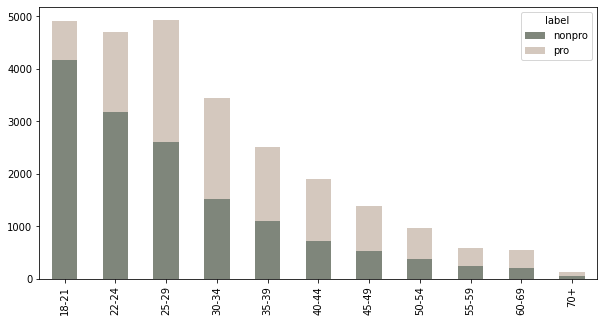

In [17]:
# 나이 크로스탭 생성
age = pd.crosstab(res['Q1'], res['label'])

# barplot
age.plot.bar(stacked=True, color={'#D4C8BE','#7F867B'}, figsize=(10, 5))
plt.xlabel('')
plt.show()

- nonpro는 18-21세가 가장 많으며, pro는 25-29세, 다음으로는 30-34세가 많다.

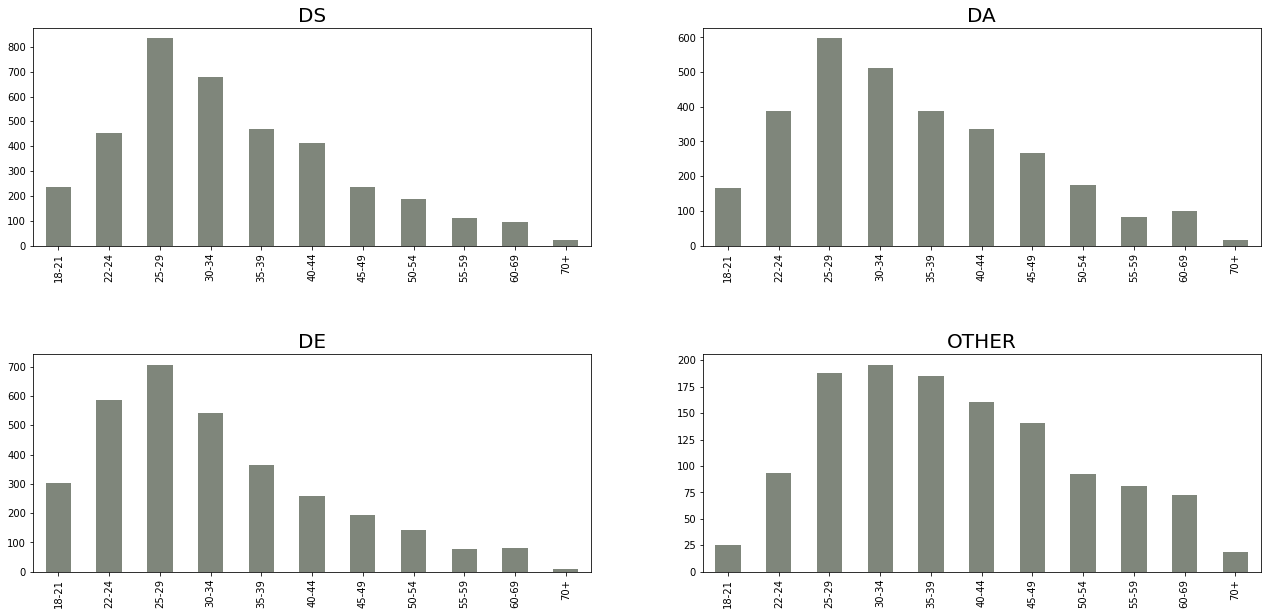

In [18]:
import itertools
plt.subplots(figsize=(22, 10))
age = pd.crosstab(pro['Q1'], pro['label'])
category = ['DS','DA','DE','OTHER']
length = len(category)
for i, j in itertools.zip_longest(category, range(length)): ## 루프돌면서 자료 묶음
  plt.subplot((length/2), 2, j+1) ## nrows, ncols, index
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  age[i].plot.bar(color='#7F867B')
  plt.title(i, size=20)
  plt.xlabel('')

plt.show()

- 전체적으로 25-29세가 가장 많으며, 다음으로 30-34세가 많으나 DE 직군은 22-24세가 많다.

##Q2. Gender

In [19]:
# crosstab
gender = pd.crosstab(res['Q2'], res['label'])
gender

label,nonpro,pro
Q2,,
Man,11265,9333
Nonbinary,51,37
Prefer not to say,196,159
Prefer to self-describe,28,14
Woman,3153,1737


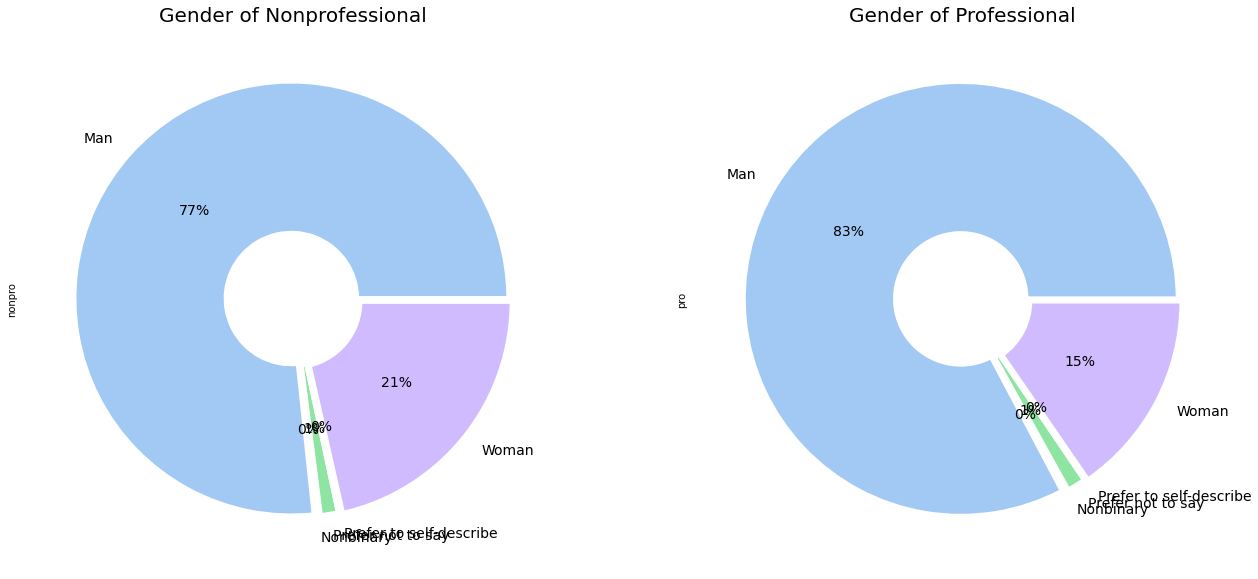

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(22, 10))
explode = [0.01, 0, 0, 0, 0.01]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
gender['nonpro'].plot.pie(autopct='%.0f%%', colors=sns.color_palette('pastel'), explode=explode, wedgeprops=wedgeprops, textprops={'fontsize': 14}, ax=ax[0])
gender['pro'].plot.pie(autopct='%.0f%%', colors=sns.color_palette('pastel'), explode=explode, wedgeprops=wedgeprops, textprops={'fontsize': 14}, ax=ax[1])
ax[0].set_title('Gender of Nonprofessional', size=20)
ax[1].set_title('Gender of Professional', size=20)
plt.show()

- Pro보다 Nonpro의 여성 비율이 높아짐

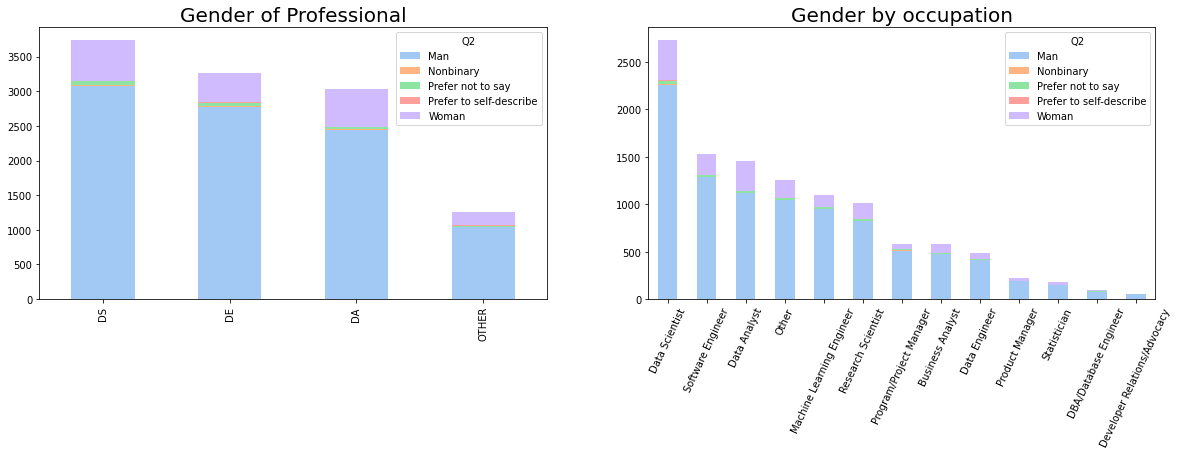

In [31]:
# barplot
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
gender = pd.crosstab(pro['Q2'], pro['label']).T.sort_values(by='Man', ascending=False)
gender.plot.bar(stacked=True, color=sns.color_palette('pastel'), ax=ax[0])

gender_spe = pd.crosstab(pro['Q2'], pro['Q5']).T.sort_values(by='Man', ascending=False)
gender_spe.plot.bar(stacked=True, color=sns.color_palette('pastel'), ax=ax[1])

ax[0].set_title('Gender of Professional', size=20)
ax[1].set_title('Gender by occupation', size=20)

ax[0].set_xlabel('')
ax[1].set_xlabel('')

plt.xticks(rotation=65)

plt.show()

- 여성 비율 DA 직군이 가장 높으며, 다음으로 DS, DE 순이다.

## Q3. Country

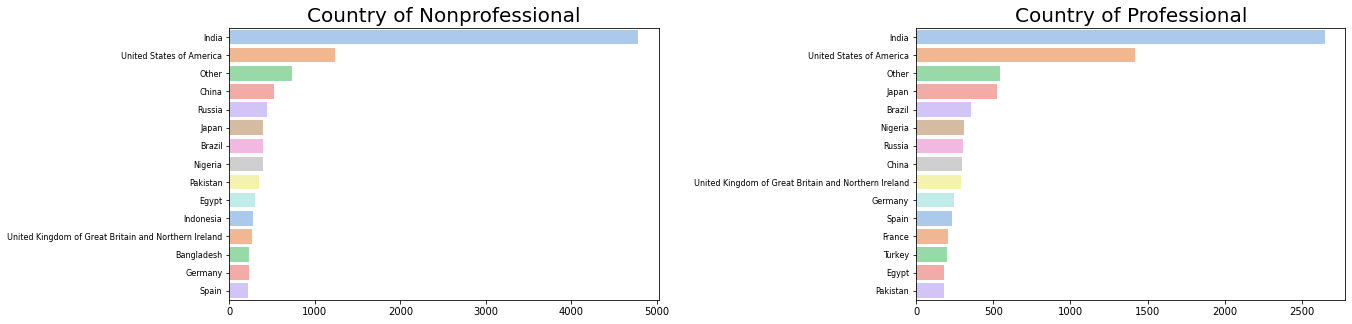

In [22]:
non_country = res[res['label'] == 'nonpro']['Q3'].value_counts()[:15]
pro_country = res[res['label'] == 'pro']['Q3'].value_counts()[:15]

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.barplot(non_country, non_country.index, palette='pastel', ax=ax[0])
sns.barplot(pro_country, pro_country.index, palette='pastel', ax=ax[1])

plt.subplots_adjust(wspace=0.6, hspace=0.5)
ax[0].set_title('Country of Nonprofessional', size=20)
ax[1].set_title('Country of Professional', size=20)
ax[0].set_yticklabels(non_country.index, fontsize=8)
ax[1].set_yticklabels(pro_country.index, fontsize=8)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.show()

- Nonpro TOP 15에 새롭게 랭크된 나라 : Indonesia, Bangladesh

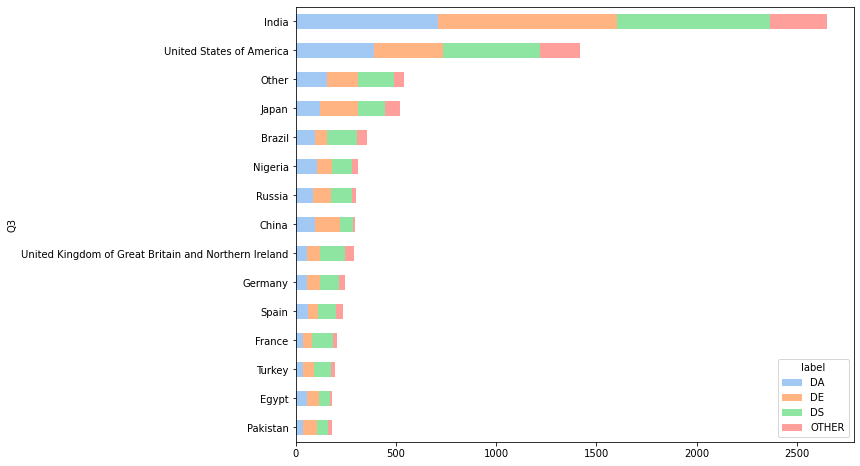

In [23]:
country_spe = pd.crosstab(pro['Q3'], pro['label'])
country_spe['total'] = country_spe['DA'] + country_spe['DE'] + country_spe['DS'] + country_spe['OTHER']
country_spe = country_spe.sort_values('total', ascending=False)[:15].sort_values('total').drop('total', axis=1)

country_spe.plot.barh(stacked=True, color=sns.color_palette('pastel'), figsize=(10, 8))
plt.show()

- US는 DE 비율이 적고, Brazil은 DS 비율이 높으며, Japan과 China는 DE 비율이 높다.

### 현직자 비율 TOP 3 국가(India, USA, Japan) 기준 직군별 연봉

- 요부분은 좀 더 고민해보기!!!!!!!

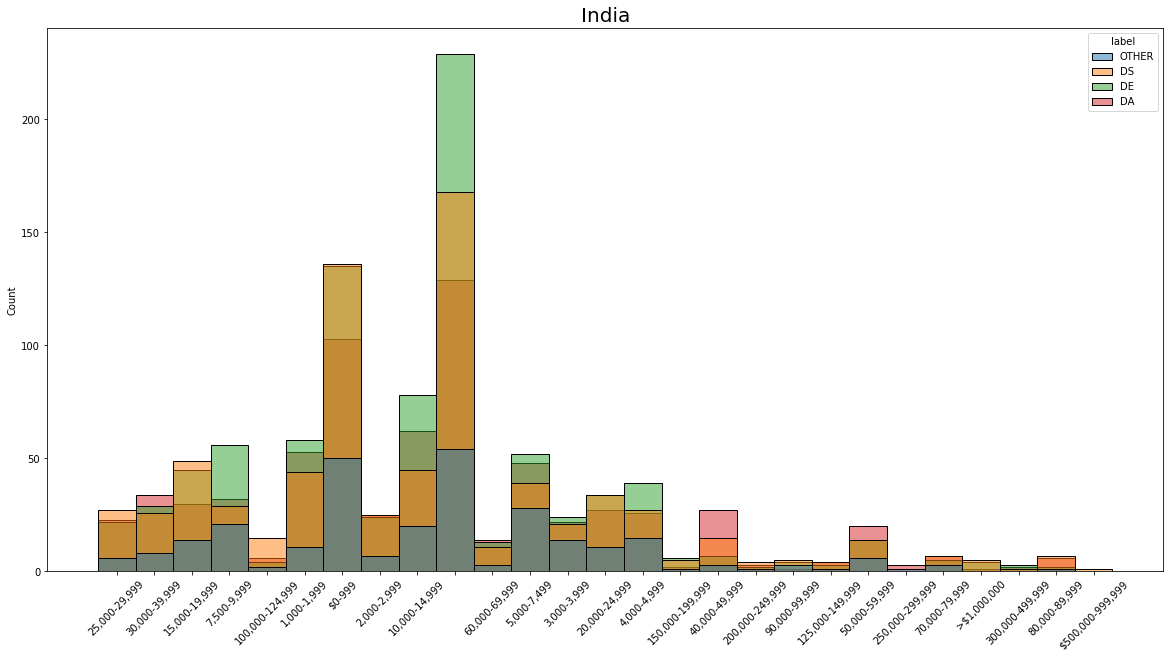

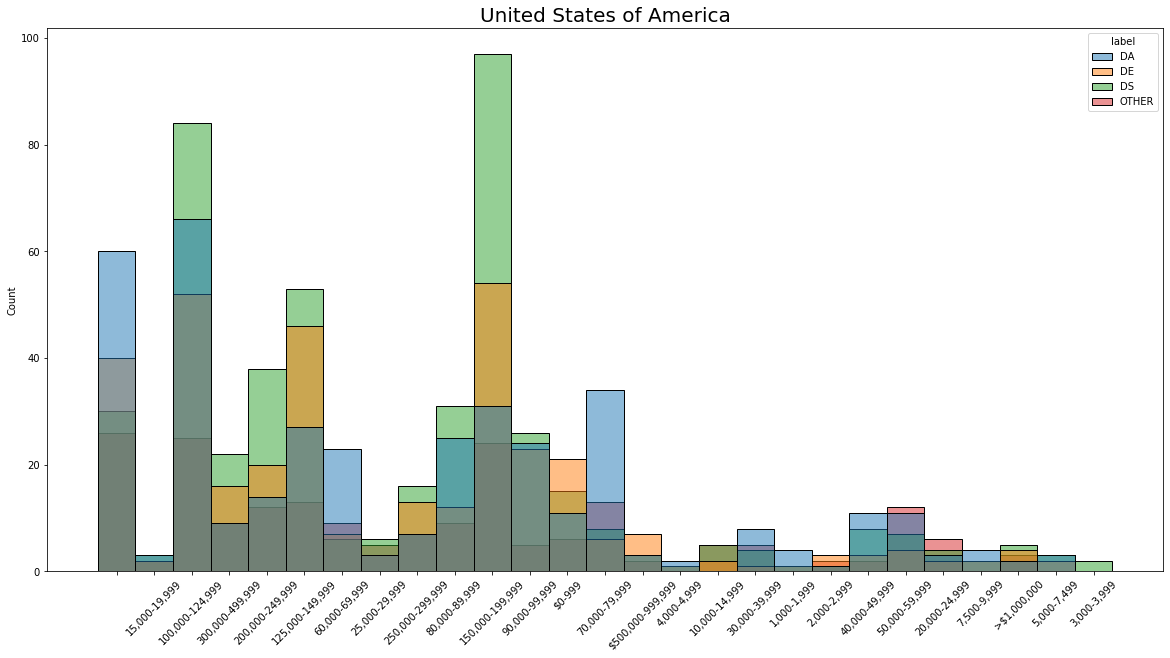

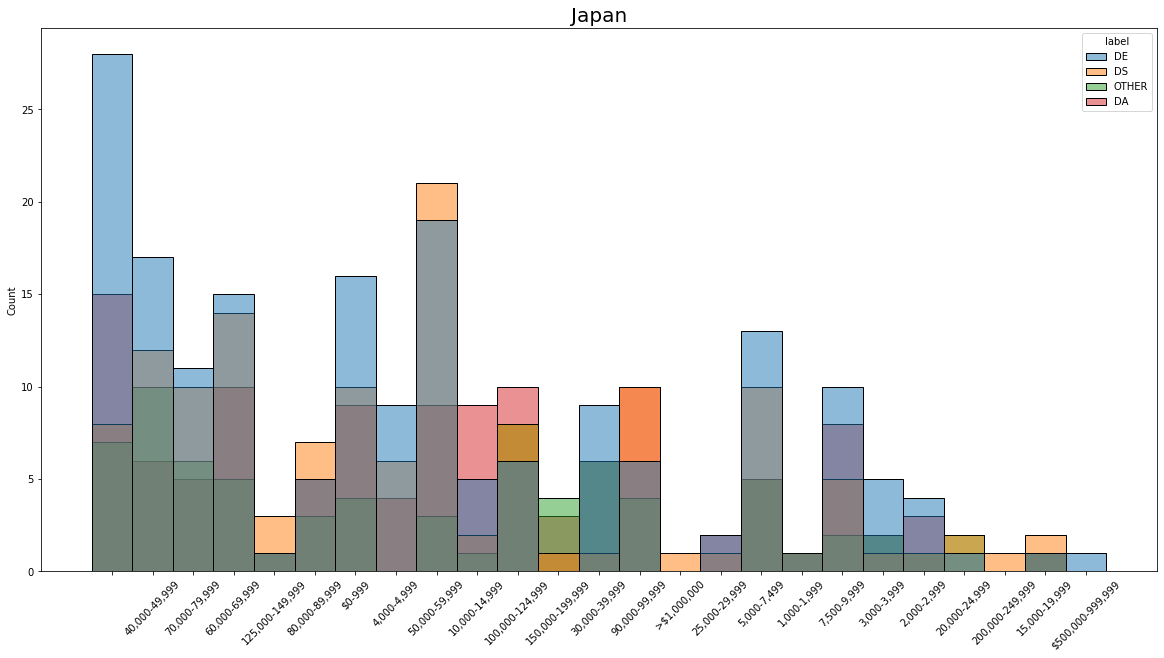

In [32]:
for i in ['India', 'United States of America', 'Japan']:
  plt.figure(figsize=(20, 10))
  ax = sns.histplot(pro[pro['Q3']==i], hue='label', x='Q25')
  plt.xticks(rotation=45)
  plt.title(i, size=20)
  plt.xlabel('')
  plt.show()

##Q4.Education

In [25]:
nonpro_edu = res[res['label'] == 'nonpro']['Q4'].value_counts().to_frame()
nonpro_edu['Q4'] = nonpro_edu['Q4']*(-1)
pro_edu =  res[res['label'] == 'pro']['Q4'].value_counts()

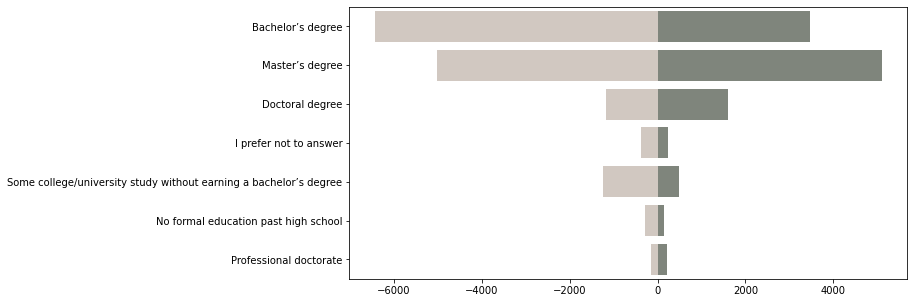

In [26]:
order = res.Q4.unique()
plt.figure(figsize=(10, 5))
bar_plot = sns.barplot(y=nonpro_edu.index, x=nonpro_edu['Q4'], order=order, color='#D4C8BE')
bar_plot = sns.barplot(y=pro_edu.index, x=pro_edu.values, order=order, color='#7F867B')
plt.xlabel('')
plt.show()

- Nonpro는 학사가 많고, pro는 석사가 많은 것으로 보아 현재 Nonpro는 석사까지 마칠 확률이 높아 보인다.

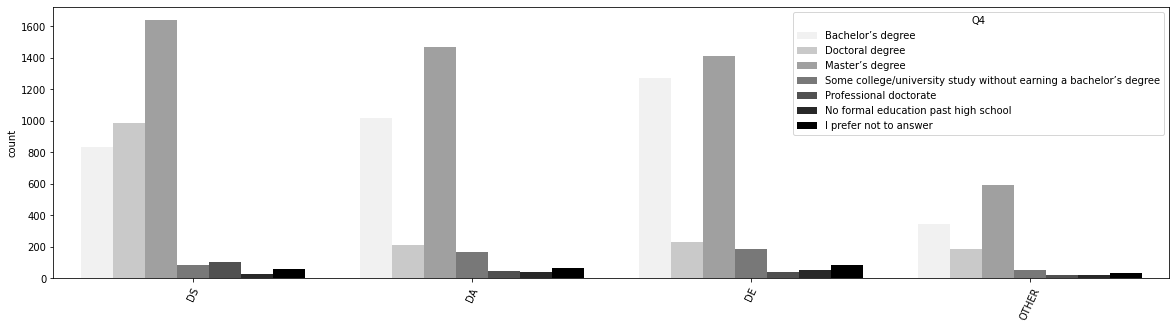

In [42]:
plt.figure(figsize=(20, 5))
sns.countplot(pro['label'], hue=pro['Q4'], color='Black', order=['DS', 'DA', 'DE', 'OTHER'])
plt.xticks(rotation=65)
plt.xlabel('')
plt.show()

DS 직군에서는 Master's degree, Doctoral degree 학위 소지자가 많다.